In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch

import numpy as np
import pandas as pd
import nn_blocks, idplots, ddpm, myutils, inpaint, ground_truth

import data_utils, data_classes
from torch.utils.data import DataLoader
from torchvision import transforms
import datetime

image_size = 64
channels = 1
batch_size=512
epoch = 800
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == "cuda":
    print(myutils.cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(myutils.cuda_mem_info())

/nas/longleaf/home/chadi/.conda/envs/diffusion_torch6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
NVIDIA L40 -- Allocated: 0.0GB, Cached: 0.0GB -- 8.9/44.3 (free/total)
NVIDIA L40 -- Allocated: 0.0GB, Cached: 0.0GB -- 8.9/44.3 (free/total)


## Prepare ground-truth for inpainting

Restored git repo Flusight/FluSight-forecast-hub/
Spatial Setup with 51 locations.
⚠️ ⚠️ ⚠️ Make sure ./update_data.sh is ran AND that the fork is updated
Checked out commit on 2023-10-25 00:00:00 (SHA: 4cfcfd1ff341b9beb0644f245aa527d3b657b707, 1698200356) for repo Flusight/FluSight-forecast-hub/
⚠️ ⚠️ ⚠️ Make sure ./update_data.sh is ran AND that the fork is updated
Restored git repo Flusight/FluSight-forecast-hub/
Masking, >> 9 weeks already in data, inpainting the next ones


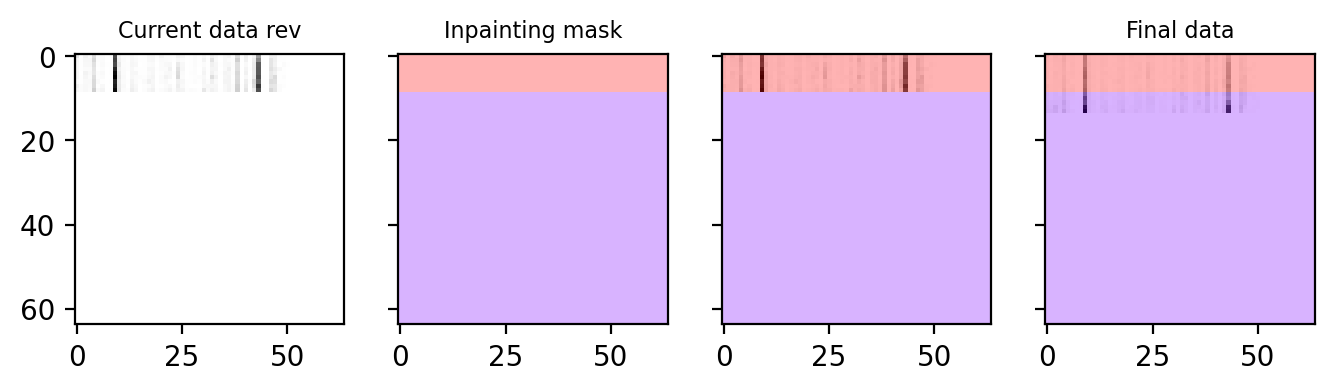

In [2]:
# if True, take a training data sample as gt:
if False: 
    inpaintfrom_idx = 19
    gt_keep_mask = np.ones((channels,image_size,image_size))
    gt_keep_mask[:,inpaintfrom_idx:,:] = 0
    # mask is ones for the known pixels, and zero for the ones to be infered
    gt = data.getitem_nocast(4)
    print(gt.shape)
    show_tensor_image(gt, place=ipl)
    plt.show()

gt1 = ground_truth.GroundTruth(season_first_year="2023", 
                               data_date=datetime.datetime(2023,10,25), 
                               mask_date=datetime.datetime.today(),
                               channels=channels,
                               image_size=image_size
                               )
gt1.plot_mask()
#gt1.plot()

## Define a PyTorch Dataset + DataLoader

In [3]:
dataset = data_classes.FluDataset.from_fluview(
                                         flusetup=gt1.flusetup,
                                         download=False, 
                                         #transform=data_classes.transform_randomscale
                                         )
dataset = data_classes.FluDataset.from_SMHR1_fluview(flusetup=gt1.flusetup, download=False)
#data = data_classes.FluDataset.from_csp_SMHR1('Flusight/flu-datasets/synthetic/CSP_FluSMHR1_weekly_padded_4scn.nc', channels=channels)
dataset.test(6)

created dataset with max [19.4177], full dataset has shape (13, 1, 64, 64)
After repeat, fluview data has shape (1170, 1, 64, 64) vs (1199, 1, 64, 64) from csp
created dataset with max [14603.53538403], full dataset has shape (2369, 1, 64, 64)
test passed: back and forth transformation are ok ✅


In [4]:
scaling_per_channel = np.array(np.sqrt(max(dataset.max_per_feature, gt1.gt_xarr.max(dim=["date", "place"])).data))
scaling_per_channel

array([120.84508837])

In [5]:
## define image transformations (e.g. using torchvision)

transform_enrich = transforms.Compose([
                        transforms.Lambda(lambda t: data_classes.transform_poisson(t)),
                        transforms.Lambda(lambda t: data_classes.transform_random_padintime(t, min_shift = -15, max_shift = 15)),
                        #transforms.Lambda(lambda t: data_classes.transform_randomscale(t, min=.1, max=1.9)),
        ])
#                         transforms.Lambda(lambda t: data_classes.transform_skewednoise(t, scale=.4, a=-1.8))
transform = transforms.Compose([
                        data_classes.transform_sqrt,
                        transforms.Lambda(lambda t: data_classes.transform_channelwisescale(t, scale = 1/scaling_per_channel)),
                        transforms.Lambda(lambda t: data_classes.transform_channelwisescale(t, scale = 2)),

        ])

# TODO: scaling on incident hops scale.

transform_inv = transforms.Compose([
                    data_classes.transform_sqrt_inv,
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale_inv(t, scale = 1/scaling_per_channel)),
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale_inv(t, scale = 2)),
        ][::-1])      # important reverse the sequence

In [6]:
dataset.add_transform(transform=transform, transform_inv=transform_inv, transform_enrich=transform_enrich, bypass_test=False)

test passed: back and forth transformation are ok ✅


In [7]:
sample = dataset[6]
print(f"There are {len(dataset)} samples in the dataset, and a single sample has shape {sample.shape}")

There are 2369 samples in the dataset, and a single sample has shape torch.Size([1, 64, 64])


In [8]:
# Dataset is shuffled, but the last incompleted batch is dropped
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True) 
batch = next(iter(dataloader))
print(f"batch shape {batch.shape}")

batch shape torch.Size([512, 1, 64, 64])


Next, we define a function which we'll apply on-the-fly on the entire dataset. We use the `with_transform` [functionality](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Dataset.with_transform) for that. The function just applies some basic image preprocessing: random horizontal flips, rescaling and finally make them have values in the $[-1,1]$ range.

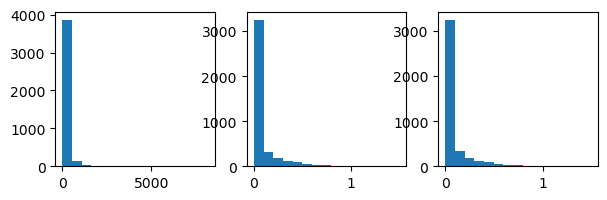

In [9]:
fig, axes = plt.subplots(1,3, figsize=(7,2))
axes.flat[0].hist(dataset.get_sample_raw(4).flatten(), bins=15);
axes.flat[1].hist(dataset.get_sample_transformed(4).flatten(), bins=15);
axes.flat[2].hist(dataset.get_sample_transformed_enriched(4).flatten(), bins=15);

In [10]:
# fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=100, sharex=True, sharey=True)
# for ipl in range(51):
#     ax = axes.flat[ipl]
#     for i in range(batch_size):
#         ax.plot(batch[i][0][:,ipl], lw=0.5)

In [11]:
gt = dataset.apply_transform(gt1.gt_xarr.data) # data.apply_transform
print(gt.shape)
gt_keep_mask = torch.from_numpy(gt1.gt_keep_mask).type(torch.FloatTensor).to(device)
gt = torch.from_numpy(gt).type(torch.FloatTensor).to(device)

(1, 64, 64)


## Initialize the DDPM class

In [12]:
model = nn_blocks.Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    use_convnext=False
)

ddpm1 = ddpm.DDPM(model=model, 
                    image_size=image_size, 
                    channels=channels, 
                    batch_size=batch_size, 
                    epochs=epoch, 
                    timesteps=200,
                    device=device)


In [13]:
import sys
sys.path.append('CoPaint4influpaint')
from guided_diffusion import O_DDIMSampler
from guided_diffusion import unet
from utils import config

In [14]:
if False:
    model = unet.UNetModel(
            image_size=image_size,
            in_channels=1,
            out_channels=1,
            num_res_blocks=3,
            model_channels=3,
            attention_resolutions=2,
        )

In [15]:
dataset
if device == "cuda":
    print(myutils.cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(myutils.cuda_mem_info())

NVIDIA L40 -- Allocated: 0.0GB, Cached: 0.0GB -- 8.9/44.3 (free/total)
NVIDIA L40 -- Allocated: 0.0GB, Cached: 0.0GB -- 8.9/44.3 (free/total)


## Forward diffusion sample

batch shape torch.Size([512, 1, 64, 64])
California


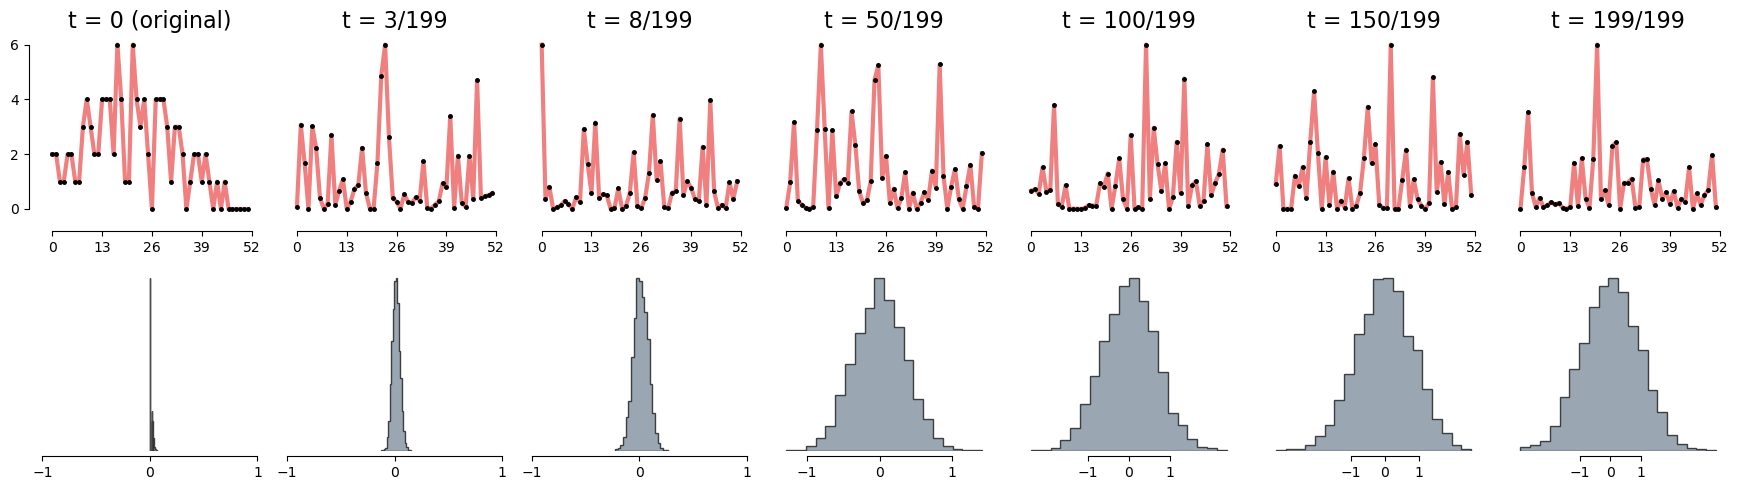

In [16]:
# use seed for reproducability
torch.manual_seed(0)
x_start = next(iter(dataloader))
print(f"batch shape {batch.shape}")

def plot(imgs, row_title=None, col_title=None, with_histogram=True, plot_size=2, **imshow_kwargs): # with_orig=False,
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    
    mult_rows=1
    if with_histogram:
        mult_rows=2

    place = 4
    color="lightcoral"#'slategray'
    print(gt1.flusetup.get_location_name(gt1.flusetup.locations[place]))
    
    num_rows = len(imgs)*mult_rows
    num_cols = len(imgs[0]) #+ with_orig
    fig, axs = plt.subplots(figsize=(plot_size*num_cols,plot_size*num_rows), nrows=num_rows, ncols=num_cols, squeeze=False, dpi=100)
    for row_idx, row in enumerate(imgs):
        # row = [transform_inv(a[place,:])] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx*mult_rows, col_idx]
            ax.plot(np.arange(52), transform_inv(np.asarray(img))[0,:52,place], **imshow_kwargs, color=color, lw=3, marker='.', markersize=5, markerfacecolor='black', markeredgecolor='black')
            ax.set_xticks(np.arange(0,53,13))
            sns.despine(ax = ax,  offset = 10, trim = True)
            if col_idx>0:
                ax.set(yticklabels=[], yticks=[])
                sns.despine(ax = ax,  offset = 10, left=True, trim = True)

            
            #ax.set_ylim(0)
            #ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if with_histogram:
                ax = axs[row_idx*mult_rows+1, col_idx]
                ax.hist(np.asarray(img).flatten(), bins=20, color='slategray', alpha=0.7, lw=1, edgecolor='k', histtype='stepfilled')
                ax.set_xticks([-1,0,1])
                ax.set(yticklabels=[], yticks=[])
                sns.despine(ax = ax,  offset = 4, left=True, trim = True)
            

    #if with_orig:
    #    axs[0, 0].set(title='Original')
    #    axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    if col_title is not None:
        for col_idx in range(num_cols):
            axs[0, col_idx].set(title=col_title[col_idx])
            axs[0, col_idx].title.set_size(16)

    plt.tight_layout()

#diffused_curves = [[q_sample(x_start[7,:], torch.tensor([t])) for t in [0, 50, 100, 150, 199]] ,
#                   [q_sample(x_start[9,:], torch.tensor([t])) for t in [0, 50, 100, 150, 199]]]#
#plot(diffused_curves, with_histogram=True)

def plot_foward_diffusion(x_start, ts, with_histogram=True, plot_size=2, **imshow_kwargs):
    if not isinstance(x_start, list):
        # Make a 2d grid even if there's just 1 row
        x_start = [x_start]
    diffused_curves = [[x] + [ddpm1.q_sample(x, torch.tensor([t])) for t in ts] for x in x_start]
    col_title = ['t = 0 (original)'] + [f't = {t}/{ddpm1.timesteps-1}' for t in ts]

    plot(diffused_curves, with_histogram=with_histogram, plot_size=plot_size, col_title=col_title, **imshow_kwargs)


plot_foward_diffusion([x_start[0,:]], ts=[3,8, 50, 100, 150, 199], with_histogram=True, plot_size= 2.5)

This means that we can now define the loss function given the model as follows:

## Train the model


In [17]:
if False:
    ddpm1.train(dataloader=dataloader)

In [18]:
checkpoint_fn = "/work/users/c/h/chadi/influpaint_res/32ac93c_2023-11-07/test::model_MyUnet200::dataset:R1Fv::trans_Lins::enrich_No-800.pth"
import epiframework

In [19]:
model_str = checkpoint_fn.split('/')[-1]
for part in model_str.split('::')[1:]:
    print(part)
    try:
        tp, val = part.split('_')
    except:
        tp, val = part.split(':')
    if tp == 'model':
        unet_spec = epiframework.model_libary(image_size=image_size, channels=channels, epoch=epoch, device=device, batch_size=batch_size)
        ddpm1 = unet_spec[val]
    elif tp == "dataset":
        dataset_spec = epiframework.dataset_library(gt1=gt1, channels=channels)
        dataset = dataset_spec[val]
    elif tp == "trans":
        scaling_per_channel = np.array(max(dataset.max_per_feature, gt1.gt_xarr.max(dim=["date", "place"])))
        transforms_spec, transform_enrich = epiframework.transform_library(scaling_per_channel=scaling_per_channel)
        transform = transforms_spec[val]
    elif tp == "enrich":
        val = val.split('-')[0]
        scaling_per_channel = np.array(max(dataset.max_per_feature, gt1.gt_xarr.max(dim=["date", "place"])))
        transforms_spec, transform_enrich = epiframework.transform_library(scaling_per_channel=scaling_per_channel)
        enrich = transform_enrich[val]
dataset.add_transform(transform=transform["reg"], transform_inv=transform["inv"], transform_enrich=enrich, bypass_test=False)

model_MyUnet200
dataset:R1Fv
After repeat, fluview data has shape (1170, 1, 64, 64) vs (1199, 1, 64, 64) from csp
created dataset with max [14603.53538403], full dataset has shape (2369, 1, 64, 64)
created dataset with max [14603.53538403], full dataset has shape (1199, 1, 64, 64)
trans_Lins
[14603.53538403]
enrich_No-800.pth
[14603.53538403]
test passed: back and forth transformation are ok ✅


In [20]:
if device == "cuda":
    print(myutils.cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(myutils.cuda_mem_info())
ddpm1.load_model_checkpoint(checkpoint_fn)
if device == "cuda":
    print(myutils.cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(myutils.cuda_mem_info())

NVIDIA L40 -- Allocated: 0.0GB, Cached: 0.0GB -- 8.9/44.3 (free/total)
NVIDIA L40 -- Allocated: 0.0GB, Cached: 0.0GB -- 8.9/44.3 (free/total)
NVIDIA L40 -- Allocated: 0.0GB, Cached: 0.0GB -- 8.9/44.3 (free/total)
NVIDIA L40 -- Allocated: 0.0GB, Cached: 0.0GB -- 8.9/44.3 (free/total)


In [21]:
if False:
    ddpm1.write_train_checkpoint()

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [22]:
if device == "cuda":
    print(myutils.cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(myutils.cuda_mem_info())

NVIDIA L40 -- Allocated: 0.0GB, Cached: 0.0GB -- 8.9/44.3 (free/total)
NVIDIA L40 -- Allocated: 0.0GB, Cached: 0.0GB -- 8.9/44.3 (free/total)


In [23]:
samples = ddpm1.sample()

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]/nas/longleaf/home/chadi/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
sampling loop time step:  80%|███████▉  | 159/200 [01:37<00:24,  1.67it/s]

In [ ]:
random_index = 0
fig, axes = plt.subplots(1, 1, figsize=(16,3), dpi=100)
ax = axes # es.flat[i]
idplots.show_tensor_image(dataset.apply_transform_inv(samples[-1][random_index]), ax = ax)
plt.show()
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels))
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(16,3), dpi=100)
ax = axes # es.flat[i]
for i in range(batch_size):
    idplots.show_tensor_image(dataset.apply_transform_inv(samples[-1][i]), ax = ax)
#ax.set_ylim(0,10000)

In [ ]:
#plt.hist(samples[-1].flatten(), bins = 100);
#plt.plot(transform_inv(samples[-1][:,0,:,:].sum(axis=2)).T);

In [ ]:
# histogram of peaks. In the US historically it's from 13k to 34k
plt.hist(transform_inv(samples[-1][:,0,:,:].sum(axis=2)).max(axis=1), bins=30)

In [ ]:
# fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=100)
# 
# for ipl in range(51):
#     ax = axes.flat[ipl]
#     for i in range(batch_size):
#         idplots.show_tensor_image(dataset.apply_transform_inv(samples[-1][i]), ax = ax, place=ipl, multi=True)

In [ ]:
animate = False
if animate:
    import matplotlib.animation as animation

    random_index = 53
# TODO: the reshape shuffles the information
    fig = plt.figure()
    ims = []
    for i in range(ddpm1.timesteps):
        im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), animated=True)
        ims.append([im])

    animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    animate.save('diffusion.gif')
    plt.show()

In [ ]:
if animate:
    plt.ioff()
    for ts in tqdm(range(0, ddpm1.timesteps, 5)):
        fig, axes = plt.subplots(8, 8, figsize=(10,10))
        for ipl in range(51):
            ax = axes.flat[ipl]
            for i in range(0,batch_size, 2):
                idplots.show_tensor_image(dataset.apply_transform_inv(samples[ts][i]), ax = ax, place=ipl)
        plt.savefig(f'results/{ts}.png')
        plt.close(fig)

## Inpatinting from copaint

In [ ]:
conf = config.Config(default_config_dict=
                    {
                        "respace_interpolate": False,
                            "ddim": {
                                "ddim_sigma": 0.0,
                                "schedule_params": {
                                    "ddpm_num_steps": 200,
                                    "jump_length": 10,
                                    "jump_n_sample": 2,
                                    "num_inference_steps": 200,
                                    "schedule_type": "linear",
                                    "time_travel_filter_type": "none",
                                    "use_timetravel": True
                                }
                            },
                            "optimize_xt": {
                                "coef_xt_reg": 0.0001,
                                "coef_xt_reg_decay": 1.01,
                                "filter_xT": False,
                                "lr_xt": 0.02,
                                "lr_xt_decay": 1.012,
                                "mid_interval_num": 1,
                                "num_iteration_optimize_xt": 2,
                                "optimize_before_time_travel": True,
                                "optimize_xt": True,
                                "use_adaptive_lr_xt": True,
                                "use_smart_lr_xt_decay": True
                            
                            },
                        "debug":False
                    },  use_argparse=False)
sampler = O_DDIMSampler(use_timesteps=np.arange(200), 
                conf=conf,
                betas=ddpm1.betas, 
                model_mean_type=None,
                model_var_type=None,
                loss_type=None)

In [ ]:
if ddpm1.device == "cuda":
    print(myutils.cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(myutils.cuda_mem_info())
    
a = sampler.p_sample_loop(model_fn=ddpm1.model, 
                     shape=(batch_size, channels, image_size, image_size),
                     conf=conf,
                     model_kwargs={"gt": gt.repeat(batch_size, 1, 1, 1),
                                    "gt_keep_mask":gt_keep_mask.repeat(batch_size, 1, 1, 1),
                                    "mymodel":True, 
                                }
                     )

## Let's add repainting from the RePaint paper

Dimensions are chanel, time, place

In [ ]:
a

In [ ]:
fluforecasts = -1*np.ones((batch_size, 1, 64, 64))

fluforecasts = all_samples[i][-1]

In [ ]:
fluforecasts = np.array(a['sample'].cpu())

In [ ]:
if device == "cuda":
    print(myutils.cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(myutils.cuda_mem_info())

In [ ]:
from importlib import reload
inpaint = reload(inpaint)
inpaint1 = inpaint.REpaint(ddpm=ddpm1,gt=gt, gt_keep_mask=gt_keep_mask)

In [ ]:
n_samples = batch_size
all_samples = []
for i in range(max(n_samples//batch_size,1)):
    samples = inpaint1.sample_paint()
    all_samples.append(samples)

In [ ]:
fluforecasts = -1*np.ones((batch_size*max(n_samples//batch_size,1), 1, 64, 64))
for i in range(max(n_samples//batch_size,1)):
    fluforecasts[i*batch_size:i*batch_size+batch_size] = all_samples[i][-1]

In [ ]:
## What does repaint do to have the 

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(5,3), dpi=200)

ax = axes
for i in range(batch_size)[::2]:
    ax.plot(gt1.gt_xarr.data[0,:gt1.inpaintfrom_idx].sum(axis=1), color='k', marker='.', ls='')
    ax.plot(dataset.apply_transform_inv(samples[-1][i])[0].sum(axis=1) , lw=.5, marker='.', markersize=1, markerfacecolor='black', markeredgecolor='black', color="lightcoral")
    idplots.show_tensor_image(samples[-1][i], ax = ax, multi=True,)
    ax.axvline(gt1.inpaintfrom_idx-1,  c='k', lw=1, ls='-.')
    ax.set_xlim(0,52)
    #ax.set_ylim(bottom=0, auto=True)
    #ax.grid(visible = True)
    ax.set_title("National")
    sns.despine(ax = ax, trim = True, offset=4)
fig.tight_layout()
plt.show()

In [ ]:
#fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=200, sharex=True)

#for ipl in range(51):
#    ax = axes.flat[ipl]
#    for i in range(min(50, batch_size)):  # print max 50 sims
#        ax.plot(gt_xarr.data[0,:inpaintfrom_idx, ipl], color='k')
#        show_tensor_image(samples[-1][i], ax = ax, place=ipl, multi=True)
#        ax.axvline(inpaintfrom_idx-1, c='k', lw=.7, ls='-.')
#        ax.set_xlim(0,52)
#        ax.set_ylim(bottom=0, auto=True)
#        ax.grid()
#        #ax.set_title(get_state_name(places[ipl]))
#fig.tight_layout()
##plt.savefig("inpainting.pdf")

In [ ]:
fluforecasts

In [ ]:
fluforecasts_ti = dataset.apply_transform_inv(fluforecasts)

In [ ]:
plt.plot(gt1.gt_xarr.data[0,:gt1.inpaintfrom_idx].sum(axis=-1))

In [ ]:
fluforecasts_ti = dataset.apply_transform_inv(fluforecasts)


# compute the national quantiles, important as sum of quantiles >> quantiles of sum
forecasts_national = fluforecasts_ti.sum(axis=-1)
forecasts_national.shape

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12,4), dpi=100)

for iax in range(2):
  ax = axes[iax]
  for iqt in range(11):
      #print(flusight_quantile_pairs[iqt,0], flusight_quantile_pairs[iqt,1])
      ax.fill_between(np.arange(64), 
                      np.quantile(forecasts_national, myutils.flusight_quantile_pairs[iqt,0], axis=0)[0], 
                      np.quantile(forecasts_national, myutils.flusight_quantile_pairs[iqt,1], axis=0)[0], alpha=.1, color='darkred')
      
  ax.plot(np.arange(64), 
          np.quantile(forecasts_national, myutils.flusight_quantiles[12], axis=0)[0], color='r')
  #ax.plot(np.arange(64), fluforecasts_ti[:,0].sum(axis=-1).T,lw=0.1, alpha=.1,  color='k')
  ax.plot(gt1.gt_xarr.data[0,:gt1.inpaintfrom_idx].sum(axis=1), color='k', marker='.', ls='')
  ax.axvline(gt1.inpaintfrom_idx-1, c='k')
  if iax==0:
    ax.set_xlim(0,52)
    ax.set_ylim(bottom=0, auto=True)
  if iax==1:
    ax.set_xlim(gt1.inpaintfrom_idx-4,gt1.inpaintfrom_idx+4)
    ax.set_ylim(bottom=0, top=1500)
  
  ax.grid(visible = True)
  ax.set_title("National")
fig.tight_layout()
plt.show()

In [ ]:
forecast_date = datetime.date(2023,11,1)
team_abbrv = "UNC_IDD-InfluPaint"
forecast_date_str=str(forecast_date)

In [ ]:
gt1.export_forecasts(fluforecasts_ti=fluforecasts_ti,
                        forecasts_national=forecasts_national,
                        directory='output',
                        prefix=team_abbrv,
                        forecast_date=forecast_date,
                        save_plot=True)

In [ ]:
 plt.savefig(f"output/UNC_IDD-InfluPaint-2023-11-01-plot50-95_2.pdf")

## Data Export

In [ ]:
import requests
requests.post("https://ntfy.sh/chadi_modeling",
     data="Notebook finshed running !",
     headers={
         "Title": "Inpainting-diffusion",
         "Priority": "urgent",
         "Tags": "warning,tada"
     })